# CS 335: Introduction to Large Language Models
## Assignment 01
### **Total Marks**: 100
### **Deadline**: Sunday, 3rd March, 2024, 11:59 PM
### **Name**: Rania Siddiqui
### **ID**: 07494

#Instructions

1. Please rename your notebook as *Assignment_1_aa1234.ipynb* before the final submission. Notebooks which do not follow appropriate naming convention will not be graded.

2. Please submit your own work. If you have any questions, please feel free to reach out to the course instructors or RA.



# Assignment Overview

In this assignment, you are required to fine tune a LLM model of your that classifies which human value category a textual arguement belongs to. Your model will evaluated against 1-baseline, random-baseline results on the following dataset: test, Nahjalbalagha, Zhihu


# Setup



In [3]:
# IMPORT ALL YOUR LIBRARIES
# SUGGESTED LIBRARIES
from tabulate import tabulate
import os
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Download Files


##Evaluator

In [4]:
# DO NOT EDIT
# RUN ONLY ONCE
!wget https://raw.githubusercontent.com/touche-webis-de/touche-code/main/semeval23/human-value-detection/evaluator/evaluator.py

--2024-03-06 15:51:01--  https://raw.githubusercontent.com/touche-webis-de/touche-code/main/semeval23/human-value-detection/evaluator/evaluator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8708 (8.5K) [text/plain]
Saving to: ‘evaluator.py.1’

evaluator.py.1      100%[===================>]   8.50K  --.-KB/s    in 0s      

2024-03-06 15:51:01 (54.0 MB/s) - ‘evaluator.py.1’ saved [8708/8708]



## 1-Baseline

In [5]:
# DO NOT EDIT
# RUN ONLY ONCE
!wget https://raw.githubusercontent.com/touche-webis-de/touche-code/main/semeval23/human-value-detection/1-baseline/1-baseline.py

--2024-03-06 15:51:05--  https://raw.githubusercontent.com/touche-webis-de/touche-code/main/semeval23/human-value-detection/1-baseline/1-baseline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3613 (3.5K) [text/plain]
Saving to: ‘1-baseline.py.1’

1-baseline.py.1     100%[===================>]   3.53K  --.-KB/s    in 0s      

2024-03-06 15:51:05 (63.1 MB/s) - ‘1-baseline.py.1’ saved [3613/3613]



## Random-Baseline

In [6]:
# DO NOT EDIT
# RUN ONLY ONCE
!wget https://raw.githubusercontent.com/touche-webis-de/touche-code/main/semeval23/human-value-detection/random-baseline/random-baseline.py

--2024-03-06 15:51:08--  https://raw.githubusercontent.com/touche-webis-de/touche-code/main/semeval23/human-value-detection/random-baseline/random-baseline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5442 (5.3K) [text/plain]
Saving to: ‘random-baseline.py.1’

random-baseline.py. 100%[===================>]   5.31K  --.-KB/s    in 0s      

2024-03-06 15:51:08 (72.8 MB/s) - ‘random-baseline.py.1’ saved [5442/5442]



## Dataset Files

In [7]:
# DO NOT EDIT
# RUN ONLY ONCE
!wget https://zenodo.org/api/records/10564870/files-archive

--2024-03-06 15:51:11--  https://zenodo.org/api/records/10564870/files-archive
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘files-archive.1’

files-archive.1         [               <=>  ]  54.70M  17.0MB/s    in 4.1s    

2024-03-06 15:51:17 (13.4 MB/s) - ‘files-archive.1’ saved [57353430]



In [8]:
# DO NOT EDIT
# RUN ONLY ONCE
!unzip /content/files-archive -d Dataset

Archive:  /content/files-archive
replace Dataset/value-categories.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
 extracting: Dataset/arguments-validation-zhihu.tsv  
 extracting: Dataset/level1-labels-training.tsv  
 extracting: Dataset/arguments-test-nahjalbalagha.tsv  
 extracting: Dataset/arguments-test.tsv  
 extracting: Dataset/arguments-training.tsv  
 extracting: Dataset/arguments-validation.tsv  
 extracting: Dataset/labels-test-nahjalbalagha.tsv  
replace Dataset/labels-test-nyt.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
 extracting: Dataset/labels-test.tsv  
 extracting: Dataset/labels-training.tsv  
 extracting: Dataset/level1-labels-test-nahjalbalagha.tsv  
 extracting: Dataset/level1-labels-test.tsv  
replace Dataset/level1-labels-test-nyt.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
 extracting: Dataset/labels-validation.tsv  
 extracting: Dataset/labels-validation-zhihu.tsv  
replace Dataset/meta-arguments-g.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace Data

In [9]:
!mkdir /content/Dataset/zhihu
!mkdir /content/Dataset/nahjalbalagha
!mkdir /content/Dataset/train
!mkdir /content/Dataset/test
!mkdir /content/Dataset/validation

mkdir: cannot create directory ‘/content/Dataset/zhihu’: File exists
mkdir: cannot create directory ‘/content/Dataset/nahjalbalagha’: File exists
mkdir: cannot create directory ‘/content/Dataset/train’: File exists
mkdir: cannot create directory ‘/content/Dataset/test’: File exists
mkdir: cannot create directory ‘/content/Dataset/validation’: File exists


In [10]:
!mv /content/Dataset/*-zhihu.tsv /content/Dataset/zhihu
!mv /content/Dataset/*-nahjalbalagha.tsv /content/Dataset/nahjalbalagha
!mv /content/Dataset/*-nahjalbalagha.tsv /content/Dataset/nahjalbalagha
!mv /content/Dataset/*-training.tsv /content/Dataset/train
!mv /content/Dataset/*-test.tsv /content/Dataset/test
!mv /content/Dataset/*-validation.tsv /content/Dataset/validation

mv: cannot stat '/content/Dataset/*-nahjalbalagha.tsv': No such file or directory


# Background Information

## Human Value Detection 2023 <br/>
## SemEval 2023 Task 4. ValueEval: Identification of Human Values behind Arguments



Given a textual argument and a human value category, classify whether or not the argument draws on that category. This task uses a set of 20 value categories compiled from the social science literature and described in our [ACL paper](https://webis.de/publications.html#kiesel_2022b). Arguments are given as premise text, conclusion text, and binary stance of the premise to the conclusion ("in favor of" or "against").

The 20 value categories are shown here on Schwartz' value continuum below:

[![JEPBxUu.md.png](https://iili.io/JEPBxUu.md.png)](https://freeimage.host/i/JEPBxUu)







## Data


Data is provided as tab-separated values files with one header line. The arguments-validation.tsv files contain one argument per line: its unique argument ID, the conclusion, the premise's stance towards the conclusion, and the premise itself. Example with tab-separated columns are shown below

<pre><span class="column">Argument ID</span>	<span class="column">Conclusion</span>	<span class="column">Stance</span>	<span class="column">Premise</span>
<span class="column">A01010</span>	<span class="column">We should prohibit school prayer</span>	<span class="column">against</span>	<span class="column">it should be allowed if the student wants to pray as long as it is not interfering with his classes</span>
<span class="column">A01011</span>	<span class="column">We should abolish the three-strikes laws</span>	<span class="column">in favor of</span>	<span class="column">three strike laws can cause young people to be put away for life without a chance to straight out their life</span>
<span class="column">A01012</span>	<span class="column">The use of public defenders should be mandatory</span>	<span class="column">in favor of</span>	<span class="column">the use of public defenders should be mandatory because some people don't have money for a lawyer and this would help those that don't</span>
</pre>

The labels-validation.tsv  files also contain one argument per line: its unique argument ID and one column for each of the 20 value categories with a 1 meaning that the argument resorts to the value category and a 0 that not. Example with tab-separated columns are shown below:

<pre><span class="column">Argument ID</span>	<span class="column">Self-direction: thought</span>	<span class="column">Self-direction: action</span>	<span class="column">Stimulation</span>	<span class="column">Hedonism</span>	<span class="column">Achievement</span>	<span class="column">Power: dominance</span>	<span class="column">Power: resources</span>	<span class="column">Face</span>	<span class="column">Security: personal</span>	<span class="column">Security: societal</span>	<span class="column">Tradition</span>	<span class="column">Conformity: rules</span>	<span class="column">Conformity: interpersonal</span>	<span class="column">Humility</span>	<span class="column">Benevolence: caring</span>	<span class="column">Benevolence: dependability</span>	<span class="column">Universalism: concern</span>	<span class="column">Universalism: nature</span>	<span class="column">Universalism: tolerance</span>	<span class="column">Universalism: objectivity</span>
<span class="column">A01010</span>	<span class="column">1</span>	<span class="column">1</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">1</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">1</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>
<span class="column">A01011</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">1</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">1</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">1</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">1</span>	<span class="column">1</span>
<span class="column">A01012</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">1</span>	<span class="column">0</span>	<span class="column">0</span>	<span class="column">0</span>
</pre>

In addition, there are other datasets for evaluating the robustness of our model: validation-zhihu from the recommendation and hotlist section of the Chinese question-answering website Zhihu, test-nahjalbalagha from and based on the Nahj al-Balagha.



## Evaluation

Runs are evaluated on the basis of F1-score, Precision, and Recall: averaged over all value categories and for each category individually.

## Baseline Results

In [11]:
# DO NOT EDIT
# RUN ONLY ONCE
!mkdir /content/baseline
!mkdir /content/output

mkdir: cannot create directory ‘/content/baseline’: File exists
mkdir: cannot create directory ‘/content/output’: File exists


### 1-Baseline

#### Test Dataset

In [12]:
# DO NOT EDIT
!python3 /content/1-baseline.py --inputDataset /content/Dataset/test --outputDataset /content/baseline
!python3 evaluator.py --inputDataset /content/Dataset/test/ --inputRun /content/baseline --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

Reading /content/Dataset/test/arguments-test.tsv
Labeling 1576 instances
Detected values: {'Security: personal', 'Achievement', 'Conformity: interpersonal', 'Humility', 'Tradition', 'Face', 'Benevolence: dependability', 'Universalism: tolerance', 'Power: dominance', 'Universalism: concern', 'Stimulation', 'Benevolence: caring', 'Hedonism', 'Universalism: objectivity', 'Universalism: nature', 'Self-direction: thought', 'Power: resources', 'Self-direction: action', 'Security: societal', 'Conformity: rules'}
Writing run file
Reading /content/Dataset/test/labels-test.tsv
Reading /content/baseline/run.tsv
Truth labels: 1576
Run labels:   1576
measure {
 key: "F1"
 value: "0.26293020308065357"
}
measure {
 key: "Precision"
 value: "0.15136421319796953"
}
measure {
 key: "Recall"
 value: "1.0"
}


#### Zhihu

In [13]:
# DO NOT EDIT
!python3 /content/1-baseline.py --inputDataset /content/Dataset/zhihu/ --outputDataset /content/baseline
!python3 evaluator.py --inputDataset /content/Dataset/zhihu/ --inputRun /content/baseline --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

Reading /content/Dataset/zhihu/arguments-validation-zhihu.tsv
Labeling 100 instances
Detected values: {'Universalism: objectivity', 'Universalism: concern', 'Conformity: rules', 'Conformity: interpersonal', 'Achievement', 'Self-direction: action', 'Universalism: nature', 'Face', 'Power: dominance', 'Stimulation', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Self-direction: thought', 'Universalism: tolerance', 'Power: resources', 'Hedonism', 'Security: personal', 'Security: societal', 'Tradition'}
Writing run file
Reading /content/Dataset/zhihu/labels-validation-zhihu.tsv
Reading /content/baseline/run.tsv
Truth labels: 100
Run labels:   100
measure {
 key: "F1"
 value: "0.2292179045745204"
}
measure {
 key: "Precision"
 value: "0.12944444444444445"
}
measure {
 key: "Recall"
 value: "1.0"
}


#### Nahjalbalagha

In [14]:
# DO NOT EDIT
!python3 /content/1-baseline.py --inputDataset /content/Dataset/nahjalbalagha/ --outputDataset /content/baseline
!python3 evaluator.py --inputDataset /content/Dataset/nahjalbalagha/ --inputRun /content/baseline --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

Reading /content/Dataset/nahjalbalagha/arguments-test-nahjalbalagha.tsv
Labeling 279 instances
Detected values: {'Hedonism', 'Security: societal', 'Tradition', 'Benevolence: dependability', 'Universalism: objectivity', 'Universalism: tolerance', 'Self-direction: action', 'Stimulation', 'Conformity: rules', 'Universalism: nature', 'Humility', 'Power: dominance', 'Conformity: interpersonal', 'Universalism: concern', 'Self-direction: thought', 'Security: personal', 'Power: resources', 'Achievement', 'Benevolence: caring', 'Face'}
Writing run file
Reading /content/Dataset/nahjalbalagha/labels-test-nahjalbalagha.tsv
Reading /content/baseline/run.tsv
Truth labels: 279
Run labels:   279
measure {
 key: "F1"
 value: "0.12845882944826426"
}
measure {
 key: "Precision"
 value: "0.0686379928315412"
}
measure {
 key: "Recall"
 value: "1.0"
}


### Random-Baseline


#### Test

In [15]:
# DO NOT EDIT
!python3 /content/random-baseline.py --inputDataset /content/Dataset/test --outputDataset /content/baseline
!python3 evaluator.py --inputDataset /content/Dataset/test/ --inputRun /content/baseline --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

Reading /content/Dataset/test/arguments-test.tsv
Labeling 1576 instances
Detected values: {'Achievement', 'Benevolence: caring', 'Universalism: nature', 'Conformity: rules', 'Power: dominance', 'Conformity: interpersonal', 'Security: societal', 'Stimulation', 'Universalism: objectivity', 'Self-direction: action', 'Security: personal', 'Tradition', 'Hedonism', 'Face', 'Humility', 'Universalism: tolerance', 'Power: resources', 'Universalism: concern', 'Benevolence: dependability', 'Self-direction: thought'}
Writing run file
Reading /content/Dataset/test/labels-test.tsv
Reading /content/baseline/run.tsv
Truth labels: 1576
Run labels:   1576
measure {
 key: "F1"
 value: "0.15262628447670806"
}
measure {
 key: "Precision"
 value: "0.14580294918461476"
}
measure {
 key: "Recall"
 value: "0.16011961593880555"
}


#### Zhihu


In [16]:
# DO NOT EDIT
!python3 /content/random-baseline.py --inputDataset /content/Dataset/zhihu/ --outputDataset /content/baseline
!python3 evaluator.py --inputDataset /content/Dataset/zhihu/ --inputRun /content/baseline --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

Reading /content/Dataset/zhihu/arguments-validation-zhihu.tsv
Labeling 100 instances
Detected values: {'Security: personal', 'Tradition', 'Hedonism', 'Universalism: nature', 'Achievement', 'Self-direction: thought', 'Power: resources', 'Universalism: tolerance', 'Humility', 'Universalism: objectivity', 'Face', 'Universalism: concern', 'Benevolence: caring', 'Self-direction: action', 'Power: dominance', 'Conformity: interpersonal', 'Security: societal', 'Benevolence: dependability', 'Conformity: rules', 'Stimulation'}
Writing run file
Reading /content/Dataset/zhihu/labels-validation-zhihu.tsv
Reading /content/baseline/run.tsv
Truth labels: 100
Run labels:   100
measure {
 key: "F1"
 value: "0.1718901327802006"
}
measure {
 key: "Precision"
 value: "0.14317654636920793"
}
measure {
 key: "Recall"
 value: "0.21500960289160628"
}


#### Nahjalbalagha

In [17]:
# DO NOT EDIT
!python3 /content/random-baseline.py --inputDataset /content/Dataset/nahjalbalagha/ --outputDataset /content/baseline
!python3 evaluator.py --inputDataset /content/Dataset/nahjalbalagha/ --inputRun /content/baseline --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

Reading /content/Dataset/nahjalbalagha/arguments-test-nahjalbalagha.tsv
Labeling 279 instances
Detected values: {'Universalism: concern', 'Achievement', 'Universalism: tolerance', 'Power: dominance', 'Universalism: objectivity', 'Universalism: nature', 'Benevolence: caring', 'Humility', 'Tradition', 'Self-direction: action', 'Hedonism', 'Stimulation', 'Power: resources', 'Security: societal', 'Face', 'Conformity: rules', 'Self-direction: thought', 'Conformity: interpersonal', 'Security: personal', 'Benevolence: dependability'}
Writing run file
Reading /content/Dataset/nahjalbalagha/labels-test-nahjalbalagha.tsv
Reading /content/baseline/run.tsv
Truth labels: 279
Run labels:   279
measure {
 key: "F1"
 value: "0.08840964389438137"
}
measure {
 key: "Precision"
 value: "0.057501857970377344"
}
measure {
 key: "Recall"
 value: "0.1911598486144446"
}


# Tasks

## [20 Points] Task 01 - Load Datasets

In this task, you are required to load the Training, Test, Validation, Nahjalbalagha & Zhihu into seperate dataframes.

In [18]:
# Write your code here
#Test Dataframe
test_dataframe = pd.read_csv('/content/Dataset/test/arguments-test.tsv', sep='\t') # loading the arguments dataset using pd.read_csv
test_dataframe_2 =pd.read_csv('/content/Dataset/test/labels-test.tsv', sep='\t') # loading the labels dataset using pd.read_csv
test_dataframe=pd.merge(test_dataframe,test_dataframe_2, on='Argument ID', how='inner') # merging the dataframes
test_dataframe


,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,1
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,E07272,We should end mass migration together.,in favor of,Mass migration is a phenomenon that causes dam...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1572,E07273,We should end mass migration together.,in favor of,Mass migration hurts the migrants themselves i...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1573,E07275,We should consider Russian interests in the EU...,in favor of,It is neither in the interests of the EU nor R...,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
1574,E07280,We should adopt an extension of the applicatio...,in favor of,Foreign Policy at the EU level should be based...,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [19]:
#Training DataFrame
train_dataframe=pd.read_csv('/content/Dataset/train/arguments-training.tsv', sep='\t') # loading train dataframe's arguments
train_dataframe_2=pd.read_csv('/content/Dataset/train/labels-training.tsv', sep='\t') # loading train_dataframe's labels
trainingdf=pd.merge(train_dataframe,train_dataframe_2, on='Argument ID', how='inner') # merging the dataframes
trainingdf

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,E08016,The EU should integrate the armed forces of it...,in favor of,"On the one hand, we have Russia killing countl...",0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
5389,E08017,Food whose production has been subsidized with...,in favor of,The subsidies were originally intended to ensu...,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
5390,E08018,Food whose production has been subsidized with...,in favor of,These products come mainly from large enterpri...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5391,E08019,Food whose production has been subsidized with...,in favor of,Subsidies often make farmers in recipient coun...,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1


In [20]:
#Validation Dataframe
validation=pd.read_csv('/content/Dataset/validation/arguments-validation.tsv', sep='\t') # loading the validation dataset arguments
validation_dataframe_2 =pd.read_csv('/content/Dataset/validation/labels-validation.tsv', sep='\t') # loading the validation dataset labels
validationdf=pd.merge(validation,validation_dataframe_2, on='Argument ID', how='inner') # merging the dataframes
validationdf

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,E08014,We should shift the EU policy toward the Russi...,in favor of,Pushing Russia to the wall will have adverse e...,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
1892,E08021,We should stop buying Russian gas,in favor of,The Russians use the money we give them in exc...,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
1893,E08022,We should stop buying Russian gas,in favor of,The cost of gas will be higher. But I prefer t...,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
1894,E08024,We should strengthen our ties with Ukraine and...,in favor of,We must support countries that want to improve...,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [21]:
#Nah Dataframe
nah_df = pd.read_csv('/content/Dataset/nahjalbalagha/arguments-test-nahjalbalagha.tsv', sep='\t') # loading the nah df args
nah_df2=pd.read_csv('/content/Dataset/nahjalbalagha/labels-test-nahjalbalagha.tsv', sep='\t') # loading labels
nahja_df=pd.merge(nah_df,nah_df2, on='Argument ID', how='inner') # merging
nahja_df

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,F01000,Habitual greed devalues humans,in favor of,Greed is like a slippery rock on which even th...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,F01001,Habitual greed devalues humans,in favor of,"Greedy people, in order to achieve their goal,...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,F01002,Habitual greed devalues humans,in favor of,Whoever adopts greed as a habit devalues himself,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,F01003,Habitual greed devalues humans,in favor of,Being greedy is eternal slavery,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F01004,Habitual greed devalues humans,in favor of,A greedy person does not see the dangers aroun...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,F01295,We should not be proud,in favor of,Arrogance destroys people,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,F01297,We should not be pessimistic,against,The worst case scenario should always be consi...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
276,F01298,We should not attribute our faults to others,in favor of,"When we ourselves have made a mistake, we cann...",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
277,F01299,Being a slave to others is a mistake,in favor of,All humans are born free and equal and no one ...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#zhihu dataframe
zhihu_df = pd.read_csv('/content/Dataset/zhihu/arguments-validation-zhihu.tsv', sep='\t') # loading the zhihu df arguments
zhihu_df2=pd.read_csv('/content/Dataset/zhihu/labels-validation-zhihu.tsv', sep='\t') # loading the labels
zhihu_df=pd.merge(zhihu_df,zhihu_df2, on='Argument ID', how='inner') # merging the df
zhihu_df

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,C26001,We should abolish the 996 overtime system,in favor of,China's 996 overtime system is very inefficien...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,C26002,We should abolish the 996 overtime system,in favor of,China's 996 overtime system leaves you with no...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,C26003,We should abolish the 996 overtime system,against,"For the poor people, if they can go to the Int...",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,C26004,We should abolish the 996 overtime system,in favor of,China's 996 overtime system violates labor laws.,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,C26005,We should abolish the 996 overtime system,against,Corporate management seeks to maximize profits...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,C26096,Carbon emissions trading should be limited.,in favor of,"To reduce carbon emissions, first of all, the ...",0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
96,C26097,Carbon emissions trading should be limited.,in favor of,The national reduction of carbon emissions wil...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
97,C26098,Carbon emissions trading should be limited.,against,Setting tough standards on carbon emissions ca...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
98,C26099,Carbon emissions trading should be limited.,in favor of,Promoting global energy conservation and emiss...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## [10 Points] Task 02 - Define Tokenizer & Model


In this task, you are required to define the Tokenizer and LLM model of your choice.

In [23]:
# Write your code here
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define the LLM model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased" , num_labels=20, problem_type="multi_label_classification")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## [20 Points] Task 03 - Optimizer & Hyperparameters


In this task, you are required to define the hyperparameters & the optimizer for training your model.

In [1]:
# Write your code here
! pip install -U accelerate
! pip install -U transformers

In [2]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir=".",
    logging_dir="./logs",
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    logging_steps=500
)

## [20 Points] Task 04 -  Training Loop


In this task, you are required to implement the training loop for fine tuning your model. You are also required to plot on the same graph: Loss vs Epochs & Accuracy vs Epochs

In [24]:
# Write your code here
class CustomDataset(Dataset):
    def __init__(self, encodings, labels): #  Initializes the CustomDataset with input encodings and corresponding labels.
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx): # Retrieves a single item from the dataset using its index and converts it into a tensor using torch.
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels) # returns the total samples in dataset.


In [25]:
lab=  ['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity']
# converted the training and validation dataframes into list, to be converted into datasets. Used this from sir munnawar's notebook.
import numpy as np
trainingdf['label'] = trainingdf[lab].values.astype(np.float32).tolist() #labels.astype(np.float32).tolist()
trainingdf["label"] = trainingdf[lab].values.tolist()

lab_val = ['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity']

validationdf['label'] = validationdf[lab].values.astype(np.float32).tolist() #labels.astype(np.float32).tolist()
validationdf["label"] = validationdf[lab].values.tolist()

In [26]:
texts = trainingdf['Premise'].tolist()
labels = trainingdf[lab].values.astype(np.float32)
encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt") # tokenized encodings
train_dataset = CustomDataset(encodings=encodings, labels=labels) # conversion into test data set using the custom dataset.


validation_texts = validationdf['Premise'].tolist()
validation_labels = validationdf[lab_val].values.astype(np.float32)
validation_encodings = tokenizer(validation_texts, truncation=True, padding=True, max_length=512, return_tensors="pt") # tokenized encodings.
validation_dataset = CustomDataset(encodings=validation_encodings, labels=validation_labels) # conversion into validation dataset using custom dataset.

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)



In [27]:
def compute_metrics(pred): # Compute metrics function for calculating accuracy given in notebook.
    labels = pred.label_ids
    preds = pred.predictions > 0.5
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
    }

In [28]:
from transformers import Trainer


trainer = Trainer( # Pre-defined Trainer Model given in notebook. Just passed the parameters in the model.
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)
trainer.train() # Trained model.

# Accessing the training logs
train_logs = trainer.state.log_history

# Accessing the evaluation metrics
eval_metrics = trainer.evaluate()

<ipython-input-24-4f587bdd3248>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.400600,0.364016,0.029008
2,0.332400,0.340367,0.051688
3,0.304200,0.335567,0.063291


<ipython-input-24-4f587bdd3248>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-24-4f587bdd3248>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-24-4f587bdd3248>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


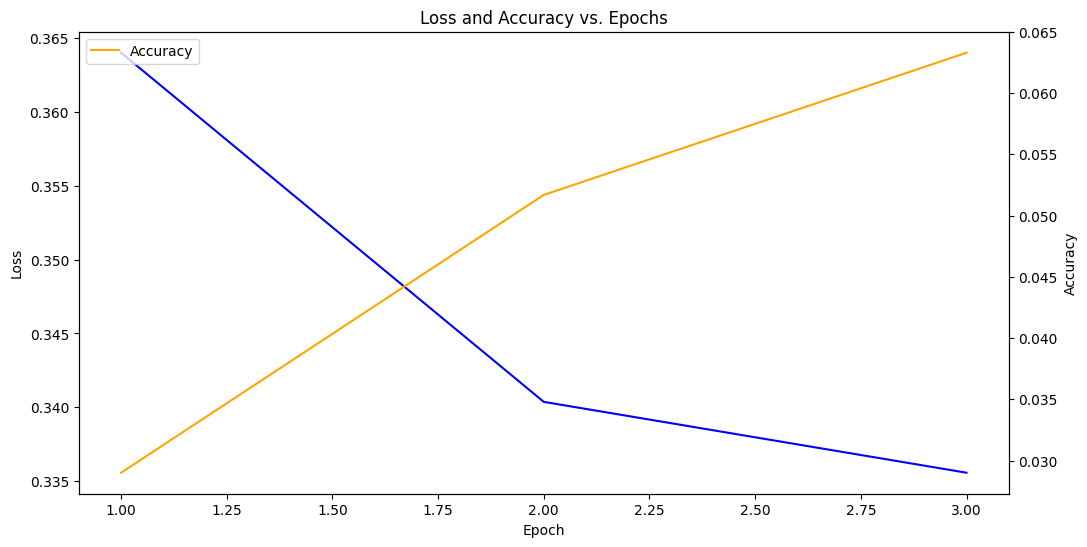

In [38]:
trainer.state.log_history # contains all the metrics during training process.
epochs = []
validation_loss = []
accuracy = []

for entry in trainer.state.log_history:
    if 'epoch' in entry and 'eval_loss' in entry and 'eval_accuracy' in entry: # if epoch, eval loss and accuracy in current entry
        epochs.append(entry['epoch']) # appending epochs
        if 'eval_loss' in entry:
            validation_loss.append(entry['eval_loss']) # appending validation losses
        if 'eval_accuracy' in entry:
            accuracy.append(entry['eval_accuracy']) # appending accuracy

# Plotting
plt.figure(figsize=(12, 6))
#Y axis for loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, validation_loss, label='Validation Loss', color='blue')

# Y-axis for the accuracy
plt.twinx()
plt.ylabel('Accuracy')
plt.plot(epochs, accuracy, label='Accuracy', color='orange')

plt.title('Loss and Accuracy vs. Epochs')
plt.legend(loc='upper left')
plt.show()


## [10 Points] Task 05 - Model Evaluation: Test Dataset

In this task, you are required your fine tuned model on the Test dataset using ``evaluator.py`` and compare your results with random and 1-baseline.

In [39]:
import csv
test_texts = test_dataframe['Premise'].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

test_dataset = CustomDataset(encodings=test_encodings, labels=test_dataframe.iloc[:, 4:].values)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
test_predictions = []
argument_ids = test_dataframe['Argument ID'].tolist()

for batch in test_dataloader:
    with torch.no_grad():
        logits = model(**{k: v.to('cuda') for k, v in batch.items()}).logits
    predictions = torch.sigmoid(logits).detach().cpu().numpy()
    test_predictions.extend(predictions)

# Convert predictions to binary
test_pred_labels = (np.array(test_predictions) > 0.5).astype(int)

# Combine 'Argument ID' with predictions
test_pred_with_ids = [[arg_id] + list(pred_labels) for arg_id, pred_labels in zip(argument_ids, test_pred_labels)]

# Save predictions with 'Argument ID' and header
predictions_path = '/content/output/test_predictions.tsv'
labels_header = pd.read_csv('/content/Dataset/test/labels-test.tsv', delimiter='\t', nrows=0).columns.tolist()

with open(predictions_path, 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(labels_header)
    writer.writerows(test_pred_with_ids)
# Run evaluation
!python /content/evaluator.py --inputDataset /content/Dataset/test/ --inputRun /content/output/ --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext


<ipython-input-24-4f587bdd3248>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Reading /content/Dataset/test/labels-test.tsv
Reading /content/output/test_predictions.tsv
Reading /content/output/zhihu_predictions.tsv
Truth labels: 1576
Run labels:   1676
Traceback (most recent call last):
  File "/content/evaluator.py", line 152, in <module>
    writeEvaluation(readLabels(args.inputDataset, prefix="labels-"), readLabels(args.inputRun), args.outputDataset)
  File "/content/evaluator.py", line 105, in writeEvaluation
    if truthLabels[argumentId][value] == "0":
KeyError: 'C26001'
measure {
 key: "F1"
 value: "0.314255102919797"
}
measure {
 key: "Precision"
 value: "0.48027921453058997"
}
measure {
 key: "Recall"
 value: "0.2335284190685612"
}


## [10 Points]  Task 06 - Model Evaluation: Zhihu Dataset

In this task, you are required your fine tuned model on the Zhihu
 dataset using ``evaluator.py`` and compare your results with random and 1-baseline.

In [47]:
import csv
zhihu_texts = zhihu_df['Premise'].tolist()
zhihu_encodings = tokenizer(zhihu_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

zhihu_dataset = CustomDataset(encodings=zhihu_encodings, labels=zhihu_df.iloc[:, 4:].values)
zhihu_dataloader = DataLoader(zhihu_dataset, batch_size=16, shuffle=False)

model.eval()
zhihu_predictions = []
argument_ids = zhihu_df['Argument ID'].tolist()

for batch in zhihu_dataloader:
    with torch.no_grad():
        logits = model(**{k: v.to('cuda') for k, v in batch.items()}).logits
    predictions = torch.sigmoid(logits).detach().cpu().numpy()
    zhihu_predictions.extend(predictions)

# Convert predictions to binary
zhihu_pred_labels = (np.array(zhihu_predictions) > 0.5).astype(int)

# Combine 'Argument ID' with predictions
zhihu_pred_with_ids = [[arg_id] + list(pred_labels) for arg_id, pred_labels in zip(argument_ids, zhihu_pred_labels)]

# Save predictions with 'Argument ID' and header
predictions_path = '/content/output/zhihu_predictions.tsv'
labels_header = pd.read_csv('/content/Dataset/zhihu/labels-validation-zhihu.tsv', delimiter='\t', nrows=0).columns.tolist()

with open(predictions_path, 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(labels_header)
    writer.writerows(zhihu_pred_with_ids)
# Evaluation
!python /content/evaluator.py --inputDataset /content/Dataset/zhihu/ --inputRun /content/output/ --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

<ipython-input-24-4f587bdd3248>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Reading /content/Dataset/zhihu/labels-validation-zhihu.tsv
Reading /content/output/test_predictions.tsv
Reading /content/output/nahja_predictions.tsv
Reading /content/output/zhihu_predictions.tsv
Truth labels: 100
Run labels:   1955
Traceback (most recent call last):
  File "/content/evaluator.py", line 152, in <module>
    writeEvaluation(readLabels(args.inputDataset, prefix="labels-"), readLabels(args.inputRun), args.outputDataset)
  File "/content/evaluator.py", line 105, in writeEvaluation
    if truthLabels[argumentId][value] == "0":
KeyError: 'A26004'
measure {
 key: "F1"
 value: "0.314255102919797"
}
measure {
 key: "Precision"
 value: "0.48027921453058997"
}
measure {
 key: "Recall"
 value: "0.2335284190685612"
}


## [10 Points]  Task 07 - Model Evaluation: Nahjalbalagha Dataset

In this task, you are required your fine tuned model on the Nahjalbalagha dataset using ``evaluator.py`` and compare your results with random and 1-baseline.

In [46]:
import csv
nahja_texts = nahja_df['Premise'].tolist()
nahja_encodings = tokenizer(nahja_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

nahja_dataset = CustomDataset(encodings=nahja_encodings, labels=nahja_df.iloc[:, 4:].values)
nahja_dataloader = DataLoader(nahja_dataset, batch_size=16, shuffle=False)

model.eval()
nahja_predictions = []
argument_ids = nahja_df['Argument ID'].tolist()

for batch in nahja_dataloader:
    with torch.no_grad():
        logits = model(**{k: v.to('cuda') for k, v in batch.items()}).logits
    predictions = torch.sigmoid(logits).detach().cpu().numpy()
    nahja_predictions.extend(predictions)

# Convert predictions to binary
nahja_pred_labels = (np.array(nahja_predictions) > 0.5).astype(int)

# Combine 'Argument ID' with predictions
nahja_pred_with_ids = [[arg_id] + list(pred_labels) for arg_id, pred_labels in zip(argument_ids, nahja_pred_labels)]

# Save predictions with 'Argument ID' and header
predictions_path = '/content/output/nahja_predictions.tsv'
labels_header = pd.read_csv('/content/Dataset/nahjalbalagha/labels-test-nahjalbalagha.tsv', delimiter='\t', nrows=0).columns.tolist()

with open(predictions_path, 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(labels_header)
    writer.writerows(nahja_pred_with_ids)

!python /content/evaluator.py --inputDataset /content/Dataset/nahjalbalagha --inputRun /content/output/ --outputDataset /content/output
!head -n 12 /content/output/evaluation.prototext

<ipython-input-24-4f587bdd3248>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Reading /content/Dataset/nahjalbalagha/labels-test-nahjalbalagha.tsv
Reading /content/output/test_predictions.tsv
Reading /content/output/nahja_predictions.tsv
Reading /content/output/zhihu_predictions.tsv
Truth labels: 279
Run labels:   1955
Traceback (most recent call last):
  File "/content/evaluator.py", line 152, in <module>
    writeEvaluation(readLabels(args.inputDataset, prefix="labels-"), readLabels(args.inputRun), args.outputDataset)
  File "/content/evaluator.py", line 105, in writeEvaluation
    if truthLabels[argumentId][value] == "0":
KeyError: 'A26004'
measure {
 key: "F1"
 value: "0.314255102919797"
}
measure {
 key: "Precision"
 value: "0.48027921453058997"
}
measure {
 key: "Recall"
 value: "0.2335284190685612"
}


# References

In this section, cite any resources or references that you use for solving this assignment.




1.   Sir Munnawar's Notebook - major and most of the help/main resource(Task1, 2, 3, 4 - taken help from the notebook)
2.   Fine-Tuning.ipynb
3.   https://huggingface.co/
4.   Chatgpt 3.5 and huggingface help in creating customdataset class
5. peer help from Dua-e-Zehra in task5




